In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
data_path='/content/drive/MyDrive/training.1600000.processed.noemoticon.csv'

In [4]:
cols = ['Sentiment','id','date','flag','user','text']
dataset = pd.read_csv(data_path,encoding='ISO-8859-1',names=cols)
dataset.tail(10)

,Sentiment,id,date,flag,user,text
1599990,4,2193579249,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,razzberry5594,WOOOOO! Xbox is back
1599991,4,2193579284,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,AgustinaP,@rmedina @LaTati Mmmm That sounds absolutely ...
1599992,4,2193579434,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,sdancingsteph,ReCoVeRiNg FrOm ThE lOnG wEeKeNd
1599993,4,2193579477,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,ChloeAmisha,@SCOOBY_GRITBOYS
1599994,4,2193579489,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,EvolveTom,"@Cliff_Forster Yeah, that does work better tha..."
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
dataset.shape

(1600000, 6)

In [6]:
# Checking for null values
dataset.isnull().any()

Sentiment    False
id           False
date         False
flag         False
user         False
text         False
dtype: bool

In [7]:
dataset = dataset[['Sentiment','text']]
dataset

,Sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
type(dataset['text'])

pandas.core.series.Series

In [9]:
print(dataset['text'][0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [10]:
print(type(dataset['text'][0]))

<class 'str'>


In [11]:
dataset['Sentiment'].value_counts()

4    800000
0    800000
Name: Sentiment, dtype: int64

In [12]:
dataset['Sentiment'] = dataset['Sentiment'].replace(4,1)
dataset['Sentiment'].value_counts()

1    800000
0    800000
Name: Sentiment, dtype: int64

([<matplotlib.axis.XTick at 0x7fba1f201f90>,
 [Text(0, 0, 'Negative'), Text(0, 0, 'Positive')])

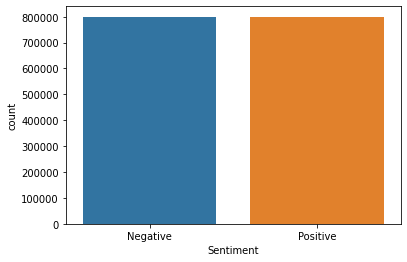

In [13]:
sns.countplot(data=dataset,x='Sentiment')
plt.xticks(ticks=[0,1],labels=['Negative','Positive'])

In [14]:
# dictionary containing all emojis.

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused',
          '$_$': 'greedy','@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused','<(-_-)>': 'robot', 'd[-_-]b': 'dj', 
          ":'-)": 'sadsmile',';)': 'wink',';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# list containing all stopwords.
stopword =  ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do','does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here','hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma','me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them','themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre","youve", 'your', 'yours', 'yourself', 'yourselves']

In [15]:
# Function to clean the data.

def preprocess(text , wordLemm):
    processedText = []
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in text:
        tweet = tweet.lower()
        
        # 

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [16]:
wordLemm = WordNetLemmatizer()
X = preprocess(list(dataset['text']),wordLemm)
y = dataset['Sentiment']

In [17]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
pd.DataFrame(X_train , y_train).info

<bound method DataFrame.info of                                                            0
Sentiment                                                   
1          USER with ya quot like palm pre touchstone cha...
1          felt the earthquake this afternoon it seems to...
1                   ruffle on shirt are like so in me likey 
0          pretty bad night into crappy morning fml if on...
1                                 USER yeah what clear view 
...                                                      ...
0          this song middle change just doesn want to be ...
1                                  USER good luck with that 
0                                       USER rather average 
0          pickin up USER waitin on USER hurry up odee mi...
0          home studying for math woot im so going to fai...

[1280000 rows x 1 columns]>

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,2), max_features=1000000,stop_words=stopword)

vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=1000000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True,
                stop_words=['a', 'about', 'above', 'after', 'again', 'ain',
                            'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at',
                            'be', 'because', 'been', 'before', 'being', 'below',
                            'between', 'both', 'by', 'can', 'd', 'did', 'do',
                            'does', 'doing', 'down', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [20]:
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb


In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## Naive Bayes Classifier

In [23]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train,y_train)

nb_pred = nb_clf.predict(X_test)
print('Naive Bayes Accuracy :',accuracy_score(y_test,nb_pred))

Naive Bayes Accuracy : 0.795725


[[128217  31277]
 [ 34091 126415]]


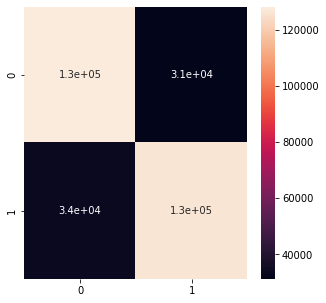

In [26]:
cm = confusion_matrix(y_test,nb_pred)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.show()

## Logistic Regression Classifier

In [24]:
log_clf = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
log_clf.fit(X_train,y_train)

log_pred = log_clf.predict(X_test)
print('Logistic Regression Accuracy :',accuracy_score(y_test,log_pred))

Logistic Regression Accuracy : 0.811928125


[[127822  31672]
 [ 28511 131995]]


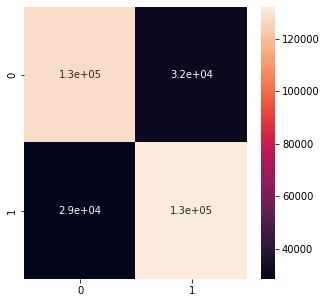

In [27]:
cm = confusion_matrix(y_test,log_pred)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.show()

## Support Vector Classification 

In [28]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

svc_pred = SVCmodel.predict(X_test)
print('SVC Model Accuracy :',accuracy_score(y_test,svc_pred))

SVC Model Accuracy : 0.80019375


[[126235  33259]
 [ 30679 129827]]


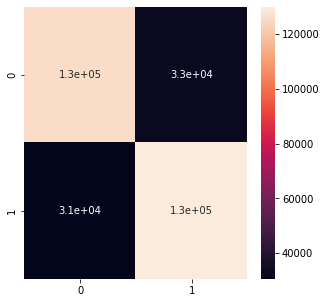

In [29]:
cm = confusion_matrix(y_test,svc_pred)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.show()

### XGBClassifier 

In [30]:
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)
xgb_clf.fit(X_train,y_train)

xgb_pred = xgb_clf.predict(X_test)
print('XGBClassifier Accuracy :',accuracy_score(y_test,xgb_pred))

XGBClassifier Accuracy : 0.688828125


[[116030  43464]
 [ 56111 104395]]


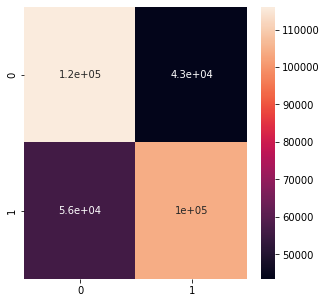

In [31]:
cm = confusion_matrix(y_test,xgb_pred)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.show()